Referred <Wrestling World Tournament - Ranking Prediction> by Julienjta
* https://www.kaggle.com/code/julienjta/wrestling-world-tournament-ranking-prediction/input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. 데이터 불러오기

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/PersonalWorks/WreslingRankPrediction/data.csv")
print("There are {} observations for {} predictors.".format(df.shape[0], df.shape[1]))
df.head()

There are 500 observations for 15 predictors.


,Unnamed: 0,name,gender,age,height,nationality,weight,sports,hours_per_day,strength,agility,mental,federation,year_start,rank
0,0,Aaron Peavy,Female,41,165.0,England,82,"Boxing, MMA",3,7,8,7,Fight Zone Wrestling,1989,42
1,1,Abe Rutland,Male,36,185.0,Japan,100,Judo,0,8,5,9,World Wrestling Entertainment,2006,161
2,2,Adrian Quinn,Male,29,178.5,Japan,93,Karate,4,8,8,7,World Wrestling Entertainment,2012,153
3,3,Alan Beckham,Male,39,187.5,Japan,107,Judo,3,7,6,8,Fight Zone Wrestling,2003,252
4,4,Albertha Rodriguez,Female,29,158.0,USA,72,MMA,1,5,7,7,Consejo Global de Lucha Libre,2012,360


2. EDA (유의미한 변수선정)

In [ ]:
df.isnull().sum()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     500 non-null    int64  
 1   name           500 non-null    object 
 2   gender         500 non-null    object 
 3   age            500 non-null    int64  
 4   height         500 non-null    float64
 5   nationality    500 non-null    object 
 6   weight         500 non-null    int64  
 7   sports         500 non-null    object 
 8   hours_per_day  500 non-null    int64  
 9   strength       500 non-null    int64  
 10  agility        500 non-null    int64  
 11  mental         500 non-null    int64  
 12  federation     500 non-null    object 
 13  year_start     500 non-null    int64  
 14  rank           500 non-null    int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 58.7+ KB


In [9]:
df.describe()

,Unnamed: 0,age,height,weight,hours_per_day,strength,agility,mental,year_start,rank
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,249.500000,31.154000,174.864000,89.688000,3.064000,6.152000,7.148000,6.732000,2007.13000,250.500000
std,144.481833,5.438514,9.468623,11.081889,1.375386,1.567741,1.455449,1.197934,6.32591,144.481833
min,0.000000,18.000000,152.000000,65.000000,0.000000,2.000000,3.000000,3.000000,1986.00000,1.000000
25%,124.750000,27.000000,167.500000,81.000000,2.000000,5.000000,6.000000,6.000000,2003.00000,125.750000
50%,249.500000,31.000000,174.000000,89.000000,3.000000,6.000000,7.000000,7.000000,2007.00000,250.500000
75%,374.250000,35.000000,181.625000,98.000000,4.000000,7.000000,8.000000,8.000000,2011.00000,375.250000
max,499.000000,53.000000,202.000000,123.000000,8.000000,10.000000,10.000000,10.000000,2021.00000,500.000000


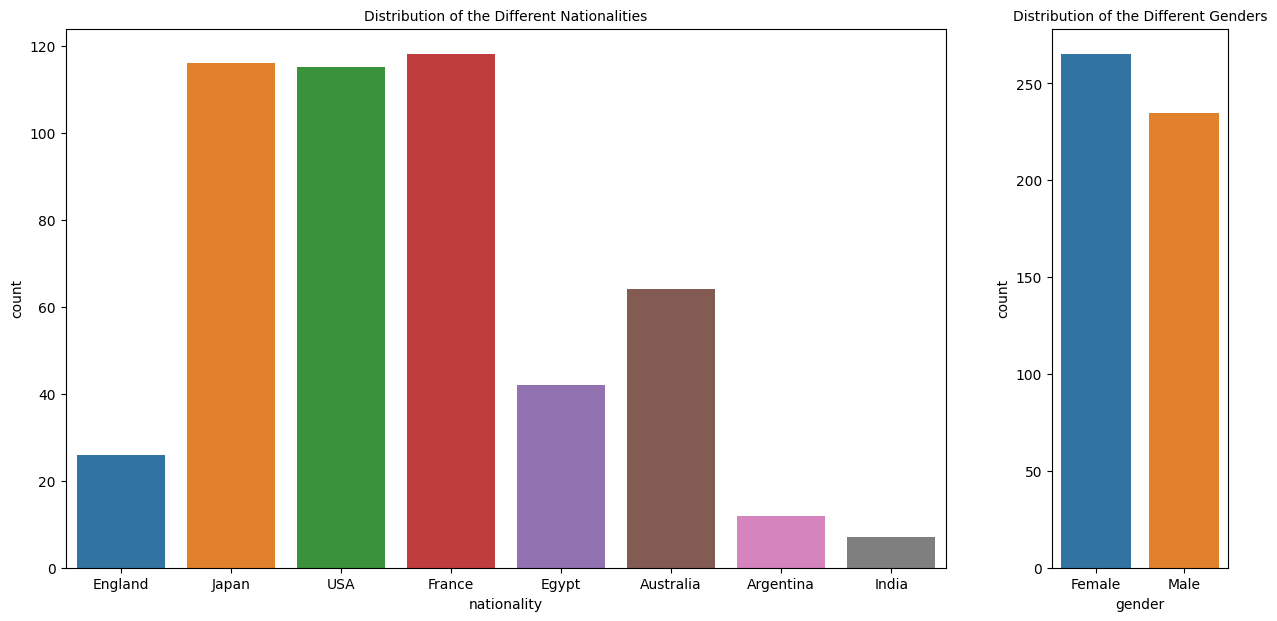

In [12]:
# Nationality, Gender
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios' : [5, 1]}, figsize = (15, 7))

sns.countplot(x='nationality', data=df, ax=axs[0]).set_title('Distribution of the Different Nationalities', fontsize=10)
sns.countplot(x='gender', data=df).set_title('Distribution of the Different Genders', fontsize=10)

plt.show()

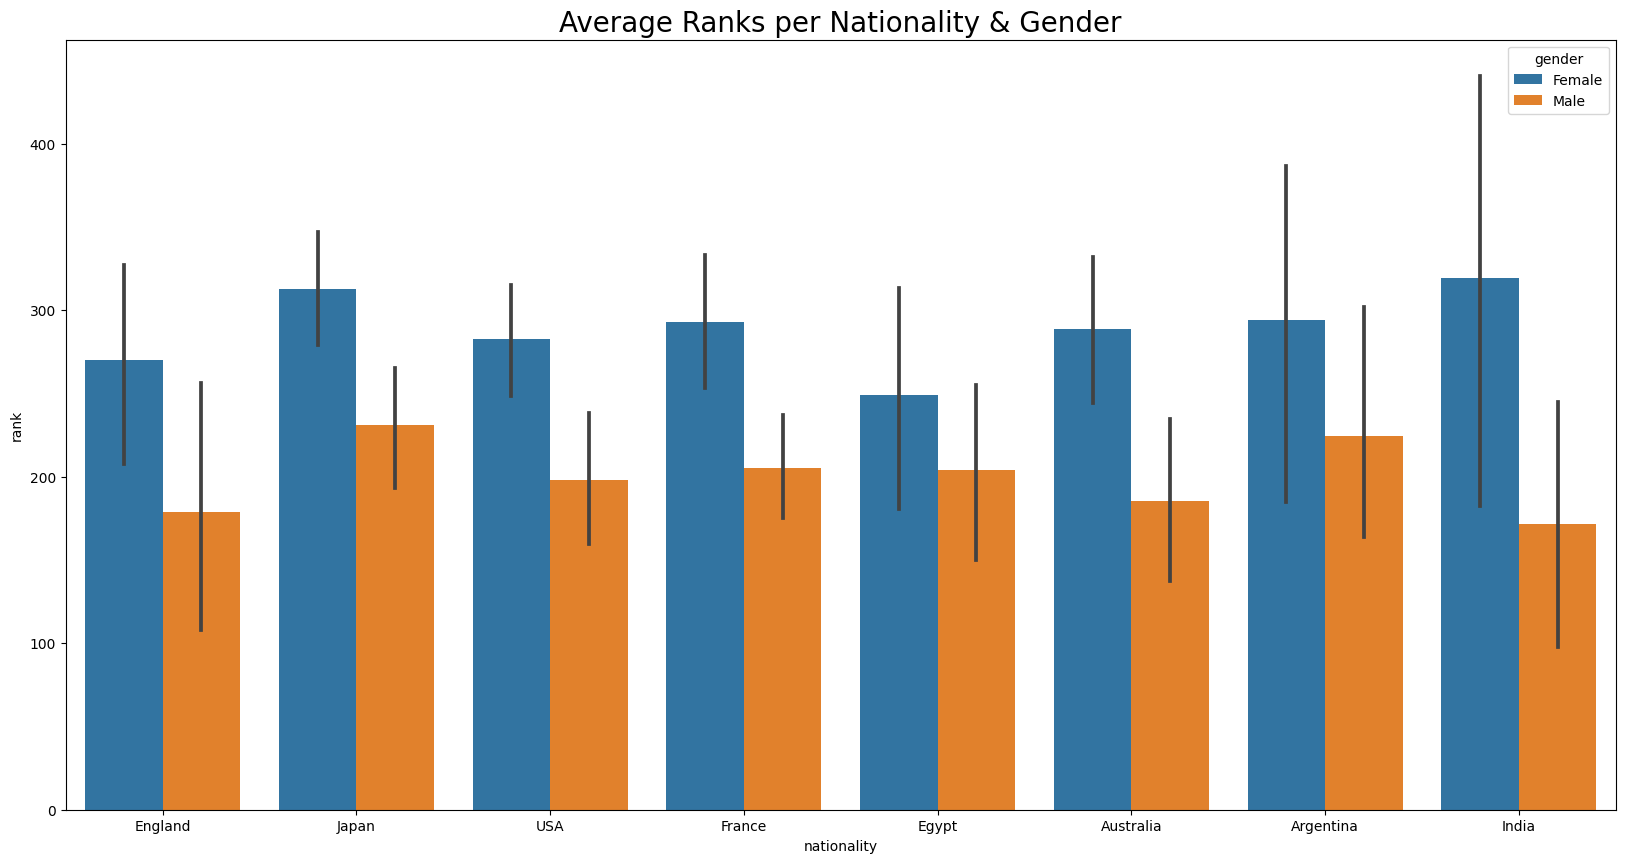

In [17]:
plt.figure(figsize=(20, 10))
sns.barplot(x='nationality', y='rank', hue='gender', data=df).set_title('Average Ranks per Nationality & Gender', fontsize=20)
plt.show()

Text(0.5, 1.0, 'Ranks based on the Weight, Height and Age')

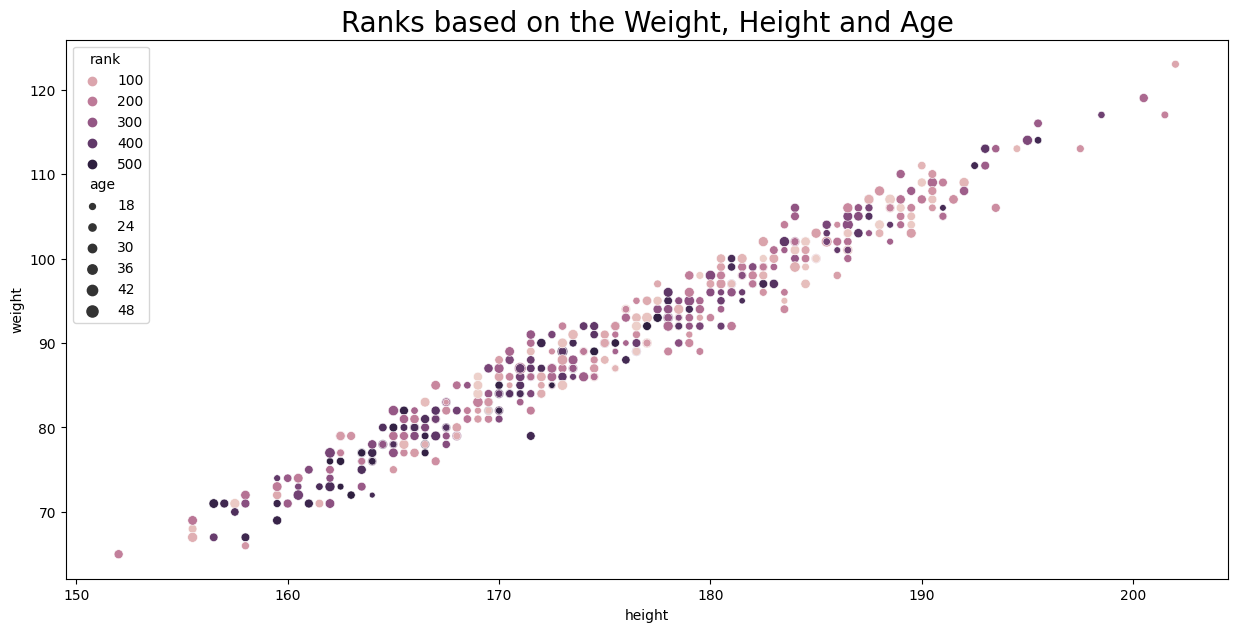

In [18]:
# Height, Weight, Age

plt.figure(figsize = (15, 7))
sns.scatterplot(x='height', y='weight', hue='rank', size='age', data=df).set_title('Ranks based on the Weight, Height and Age', fontsize=20)


In [23]:
# Related Sports
df['sports'].value_counts()

boxing = []
mma = []
judo = []
karate = []
kick = []

for sport in df['sports']:
  sport = sport.replace(',',' ')
  sport = sport.split()
  boxing.append(1 if "Boxing" in sport else 0)
  mma.append(1 if 'MMA' in sport else 0)
  judo.append(1 if "Judo" in sport else 0)
  karate.append(1 if "Karate" in sport else 0)
  kick.append(1 if "Kick-Boxing" in sport else 0)
df['boxing'] = boxing
df['mma'] = mma
df['judo'] = judo
df['karate'] = karate
df['kick'] = kick

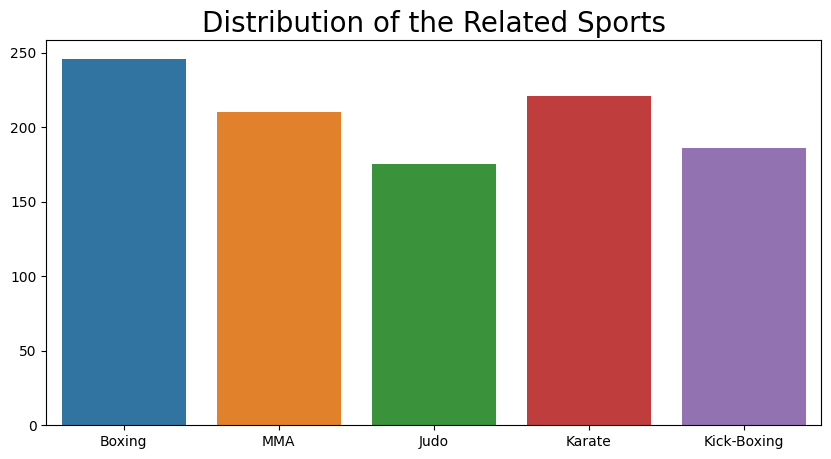

In [28]:
# Distribution of the related sports
count_sports = df[['boxing', 'mma', 'judo', 'karate', 'kick']].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x = ["Boxing", "MMA", "Judo", 'Karate', 'Kick-Boxing'], y = count_sports.values).set_title('Distribution of the Related Sports',
                                                                                                       fontsize=20)
plt.show()

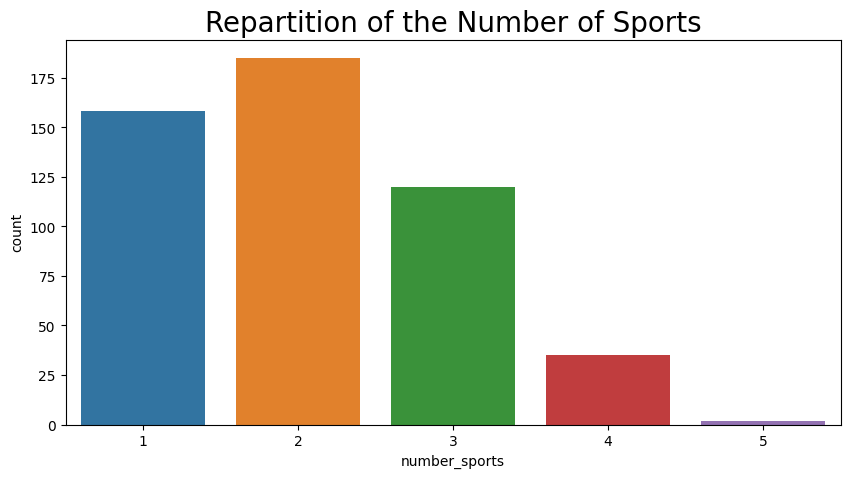

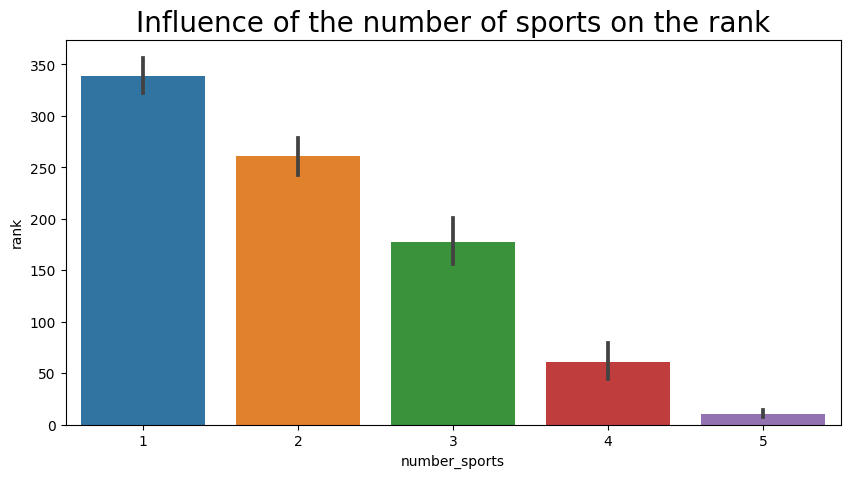

In [30]:
# Number of Sports
df['number_sports'] = df['boxing'] + df['mma'] + df['judo'] + df['karate'] + df['kick']

plt.figure(figsize=(10,5))
sns.countplot(x=df['number_sports']).set_title('Repartition of the Number of Sports', fontsize=20)

plt.figure(figsize=(10,5))
sns.barplot(x='number_sports', y='rank', data=df).set_title('Influence of the number of sports on the rank',fontsize=20)

plt.show()

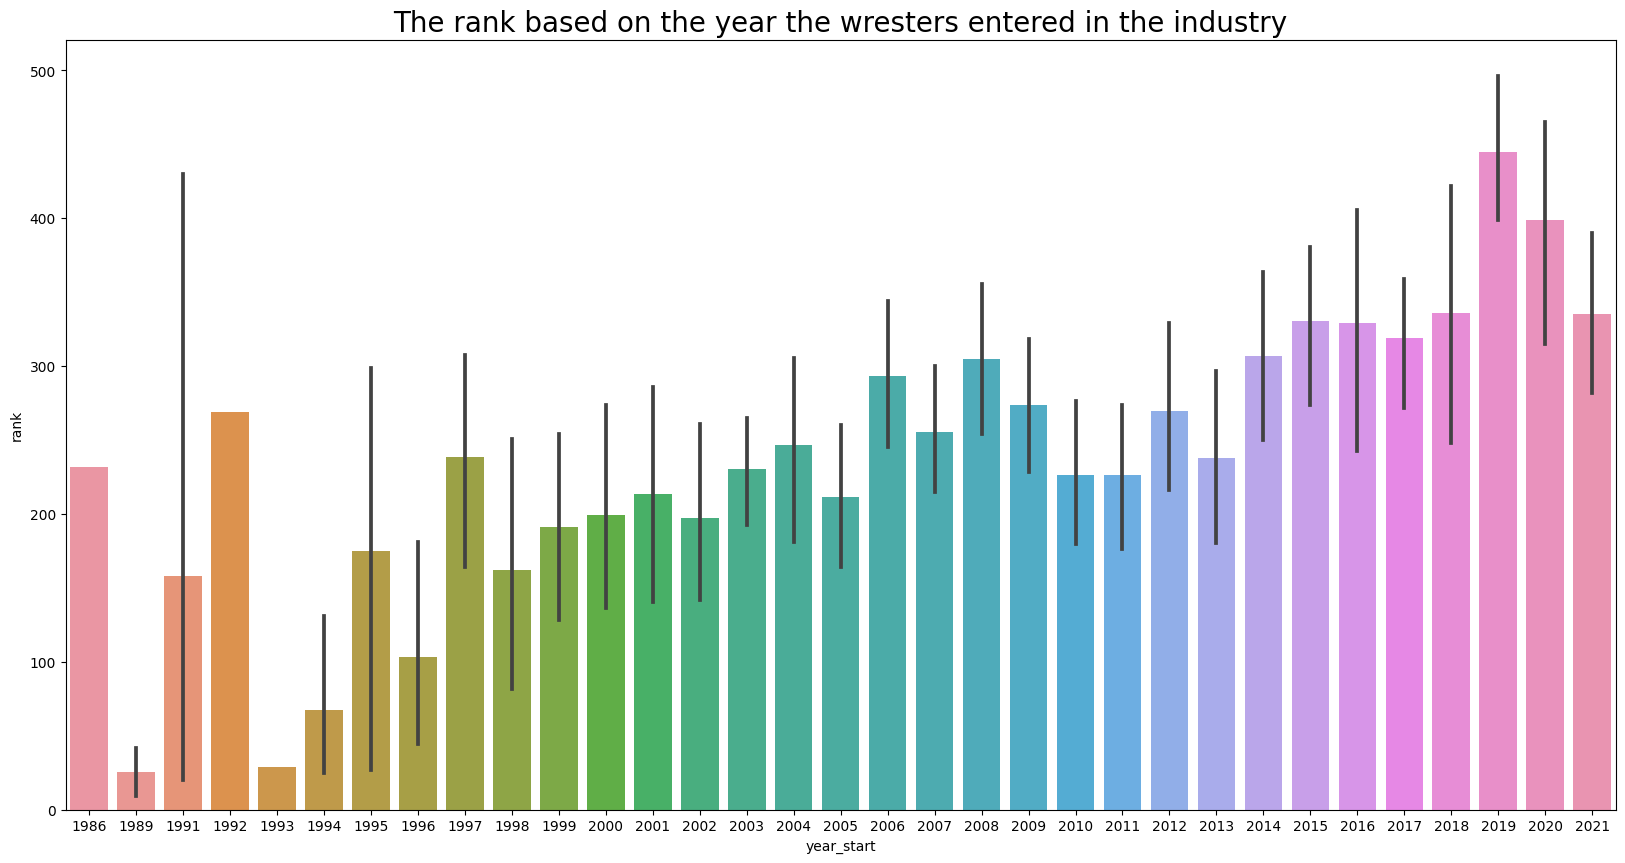

In [32]:
# Practice of the sport

plt.figure(figsize=(20, 10))
sns.barplot(x='year_start', y='rank', data=df).set_title('The rank based on the year the wresters entered in the industry',fontsize=20)
plt.show()

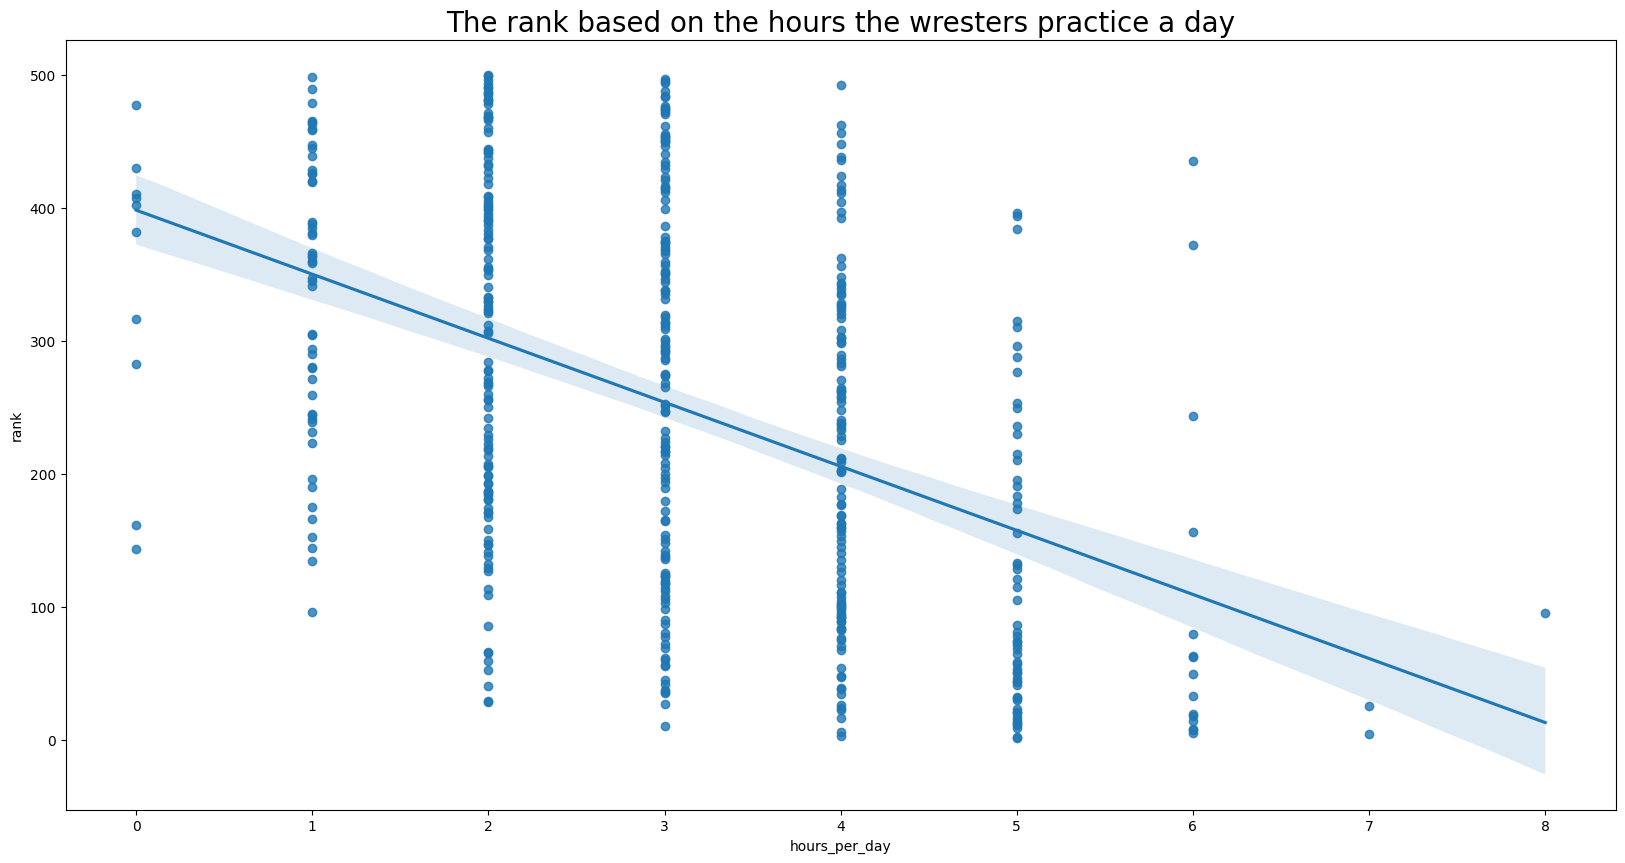

In [33]:
plt.figure(figsize=(20, 10))
sns.regplot(x="hours_per_day", y="rank", data=df).set_title('The rank based on the hours the wresters practice a day',fontsize=20)
plt.show()

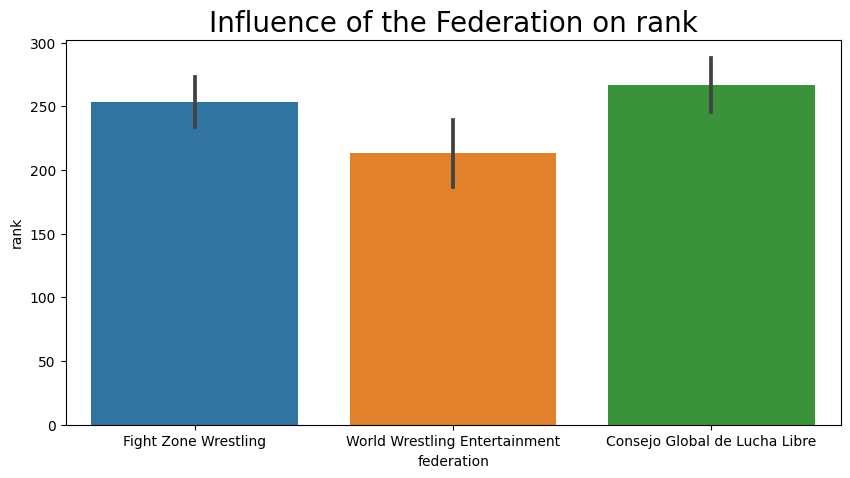

In [28]:
# Federation?
plt.figure(figsize=(10,5))
sns.barplot(x='federation', y='rank', data=df).set_title('Influence of the Federation on rank', fontsize=20)
plt.show()

<ipython-input-6-9bd6d31a368c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),


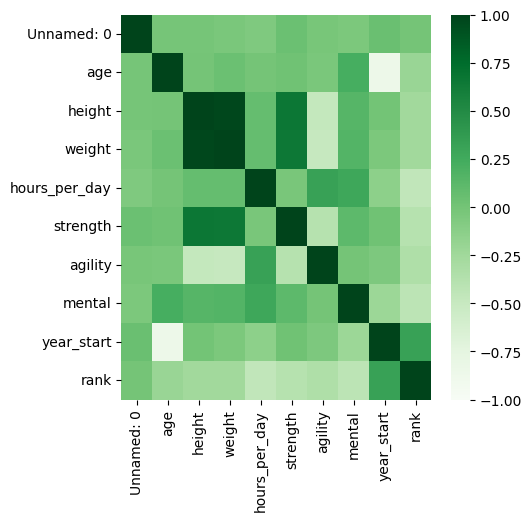

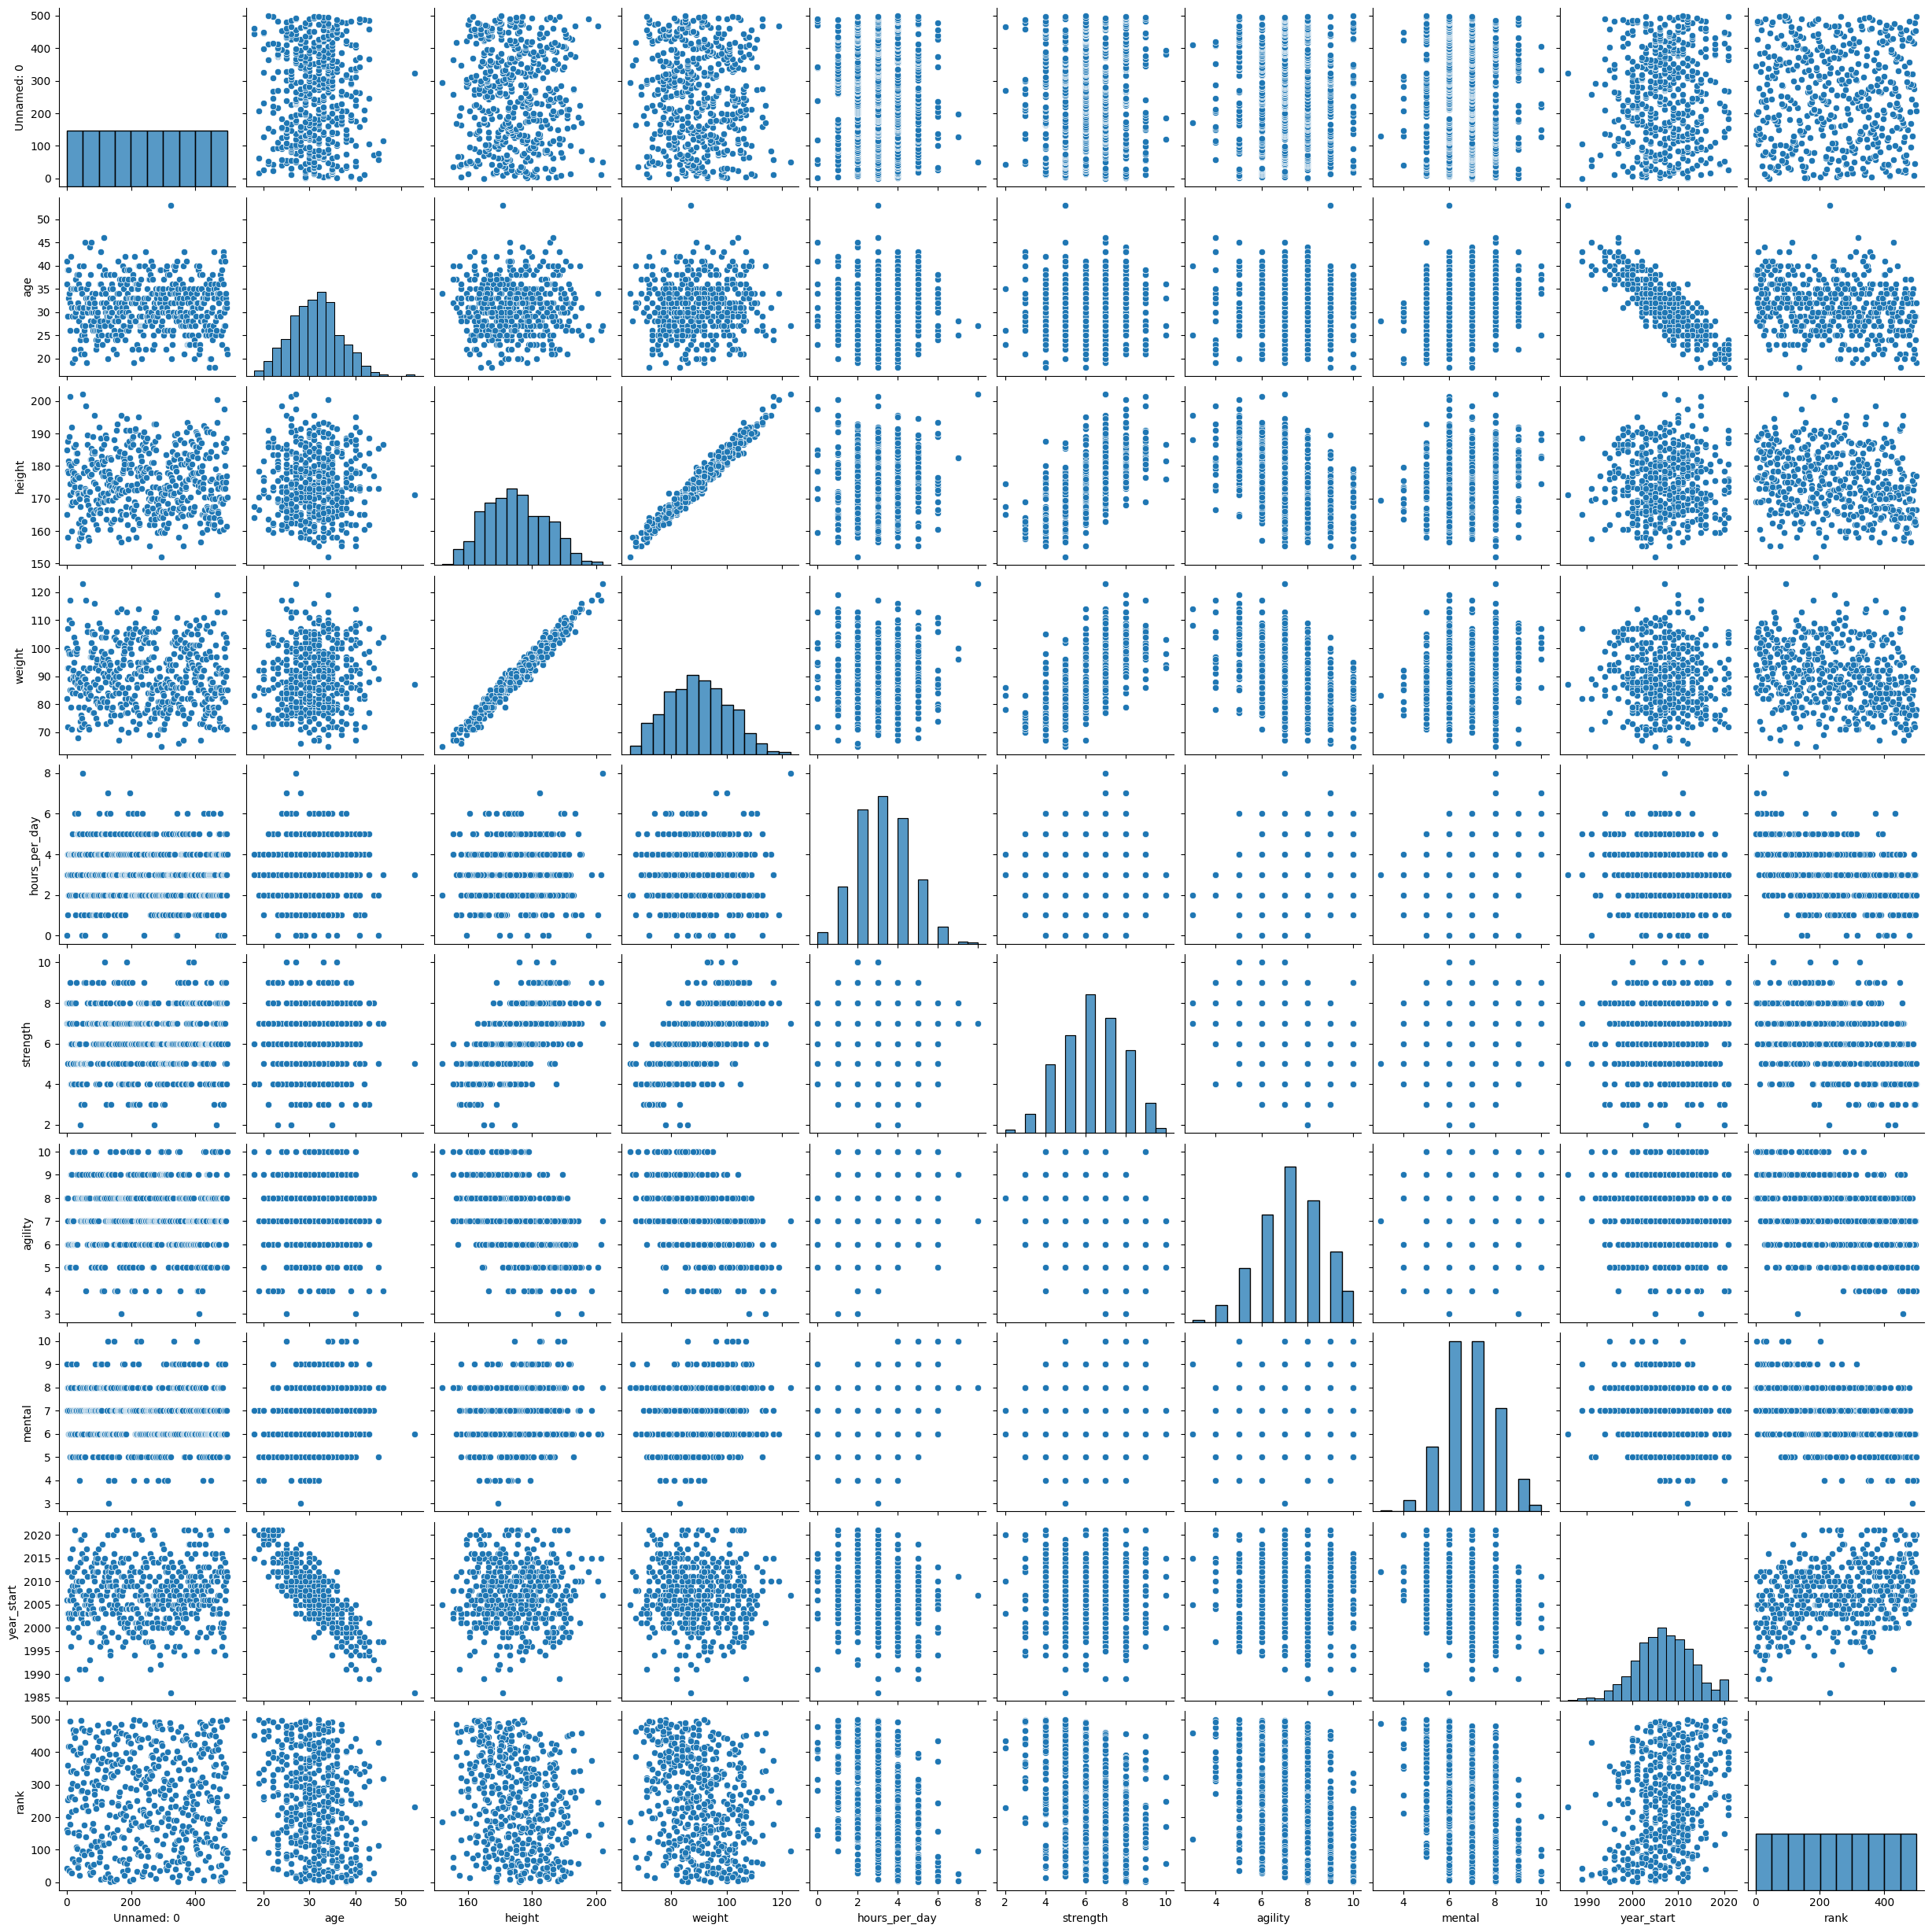

In [6]:
# 추가 상관관계 분석
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(df.corr(),
           annot = False, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )
sns.pairplot(df)
plt.show()

In [15]:
df.corr()

<ipython-input-15-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Unnamed: 0,age,height,weight,hours_per_day,strength,agility,mental,year_start,rank
Unnamed: 0,1.000000,-0.011577,-0.008069,-0.036920,-0.061164,0.044723,-0.018231,-0.045365,0.049089,-0.002339
age,-0.011577,1.000000,-0.001694,0.044624,-0.003731,0.016052,-0.036051,0.219514,-0.858723,-0.208136
height,-0.008069,-0.001694,1.000000,0.982154,0.072840,0.658785,-0.484157,0.144129,0.005482,-0.251894
weight,-0.036920,0.044624,0.982154,1.000000,0.071260,0.654799,-0.486668,0.157628,-0.039413,-0.257785
hours_per_day,-0.061164,-0.003731,0.072840,0.071260,1.000000,-0.025897,0.326623,0.275585,-0.136393,-0.458479
strength,0.044723,0.016052,0.658785,0.654799,-0.025897,1.000000,-0.384900,0.116703,0.017604,-0.383859
agility,-0.018231,-0.036051,-0.484157,-0.486668,0.326623,-0.384900,1.000000,-0.005940,-0.054115,-0.343249
mental,-0.045365,0.219514,0.144129,0.157628,0.275585,0.116703,-0.005940,1.000000,-0.218854,-0.423994
year_start,0.049089,-0.858723,0.005482,-0.039413,-0.136393,0.017604,-0.054115,-0.218854,1.000000,0.323980
rank,-0.002339,-0.208136,-0.251894,-0.257785,-0.458479,-0.383859,-0.343249,-0.423994,0.323980,1.000000


In [ ]:
!pip install statsmodels
import statsmodels.api as sm

In [27]:
y = df['rank']
x = df['hours_per_day']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     132.5
Date:                Mon, 01 May 2023   Prob (F-statistic):           2.34e-27
Time:                        08:00:54   Log-Likelihood:                -3136.6
No. Observations:                 500   AIC:                             6277.
Df Residuals:                     498   BIC:                             6286.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           398.0696     14.048     28.337

3. ML 예측 모델

In [33]:
def load_data():
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(df.select_dtypes(exclude=["object", "category"]))
  df_scaled = pd.DataFrame(data=scaled_data, columns=df.select_dtypes(exclude=['object', 'category']).columns)

  X = df_scaled.copy()
  y = X.pop('rank')
  y = df['rank']

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.3, 
                                                      shuffle = True)
  
  return X_train, X_test, y_train, y_test

In [36]:
X_train, X_test, y_train, y_test = load_data()
X_train.head()

Unnamed: 0       150
age              150
height           150
weight           150
hours_per_day    150
strength         150
agility          150
mental           150
year_start       150
gender_bin       150
dtype: int64

In [38]:
models = {}

models["KNN"] = {'model': KNeighborsRegressor(n_neighbors = 50)}
models["Linear"] = {'model': LinearRegression()}
models["XGB"] = {'model': XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, random_state=1)}
models['CatBoost'] = {'model':CatBoostRegressor(logging_level ='Silent',iterations=500,random_state=1)}

In [39]:
def score_dataset(X, y, model):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    score_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    score_r2 = score_r2.mean()
    
    return score_r2

def get_scores(models,X_train,y_train):
  for name,model in models.items():
      model["model"].fit(X_train,y_train)

      score_r2 = score_dataset(X_train, y_train, model=model["model"])
      score = {'model':"Linear regression", 'score_r2':score_r2}
      print("--- "+name+" ---")
      print("Score r2: {}".format(score_r2))
      print("\n")

get_scores(models,X_train,y_train)


--- KNN ---
Score r2: 0.33214930600330356


--- Linear ---
Score r2: 0.6487564227863337


--- XGB ---
Score r2: 0.46764156103902843


--- CatBoost ---
Score r2: 0.5667951273505698




In [41]:
model = models["Linear"]["model"]
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Rank Prediction', fontsize=20)
ax.set_ylabel('Predicted Rank', fontsize=12)
ax.set_xlabel('Actual Rank', fontsize=12)
ax.scatter(y_test, y_pred)

score_r2 = r2_score(y_test, y_pred)
score_mae = mean_absolute_error(y_test, y_pred)
plt.text(0,500,'$ R^{2} $ = ' + str(round(score_r2, 4)), fontsize=20)
plt.text(0,450,'MAE = ' + str(round(score_mae)), fontsize=20)
plt.show()

4. LSTM 모델 시도 [추가]

In [48]:
df.head()

,Unnamed: 0,name,gender,age,height,nationality,weight,sports,hours_per_day,strength,agility,mental,federation,year_start,rank,gender_bin
0,0,Aaron Peavy,Female,41,165.0,England,82,"Boxing, MMA",3,7,8,7,Fight Zone Wrestling,1989,42,False
1,1,Abe Rutland,Male,36,185.0,Japan,100,Judo,0,8,5,9,World Wrestling Entertainment,2006,161,True
2,2,Adrian Quinn,Male,29,178.5,Japan,93,Karate,4,8,8,7,World Wrestling Entertainment,2012,153,True
3,3,Alan Beckham,Male,39,187.5,Japan,107,Judo,3,7,6,8,Fight Zone Wrestling,2003,252,True
4,4,Albertha Rodriguez,Female,29,158.0,USA,72,MMA,1,5,7,7,Consejo Global de Lucha Libre,2012,360,False


In [61]:
def load_data():
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(df.select_dtypes(exclude=["object", "category"]))
  df_scaled = pd.DataFrame(data=scaled_data, columns=df.select_dtypes(exclude=['object', 'category']).columns)

  X = df_scaled.copy()
  y = X.pop('rank')
  y = df['rank']

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.3, 
                                                      shuffle = True)
  
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

In [75]:
X_train.pop('Unnamed: 0')
X_test.pop('Unnamed: 0')

304    0.609218
340    0.681363
47     0.094188
67     0.134269
479    0.959920
         ...   
331    0.663327
197    0.394790
95     0.190381
122    0.244489
23     0.046092
Name: Unnamed: 0, Length: 150, dtype: float64

In [76]:
X_train

,age,height,weight,hours_per_day,strength,agility,mental,year_start,gender_bin
13,0.485714,0.32,0.241379,0.500,0.500,0.857143,0.428571,0.485714,0.0
61,0.028571,0.37,0.362069,0.375,0.250,0.571429,0.571429,0.885714,0.0
298,0.457143,0.24,0.189655,0.250,0.125,0.571429,0.428571,0.571429,0.0
39,0.628571,0.11,0.103448,0.625,0.375,1.000000,0.714286,0.142857,0.0
360,0.514286,0.25,0.224138,0.500,0.375,0.285714,0.571429,0.400000,0.0
...,...,...,...,...,...,...,...,...,...
255,0.314286,0.36,0.379310,0.375,0.375,0.714286,0.714286,0.657143,0.0
72,0.742857,0.50,0.482759,0.250,0.750,0.714286,0.571429,0.200000,1.0
396,0.171429,0.31,0.258621,0.375,0.500,0.571429,0.428571,0.657143,0.0
235,0.257143,0.47,0.379310,0.750,0.375,0.857143,0.571429,0.571429,1.0


In [63]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [103]:
model = Sequential()
model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=(10,9))) # 여기서 데이터를 3차원으로 넣어줘야하는데..
model.add(Dropout(0.1))
model.add(LSTM(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 5)              300       
                                                                 
 dropout_16 (Dropout)        (None, 5, 5)              0         
                                                                 
 lstm_21 (LSTM)              (None, 5)                 220       
                                                                 
 dropout_17 (Dropout)        (None, 5)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 526
Trainable params: 526
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=70, batch_size=30) # 데이터가 2차원이라 돌아가지 않는 상황.... 
y_pred = model.predict(X_test)

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Rank Prediction', fontsize=20)
ax.set_ylabel('Predicted Rank', fontsize=12)
ax.set_xlabel('Actual Rank', fontsize=12)
ax.scatter(y_test, y_pred)

plt.show()